# Source finding demo

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from scipy.special import erf
from scipy.special import erfinv
from scipy.spatial import ConvexHull
from astropy.io import fits
from time import time as time

from numba import njit
from photutils import segmentation as segm

*TODO*: Properly support repeated values (infinite density)

In [2]:
class SortedData(object):
    
    def __init__(self, data, nbins=None):
        
        t0 = time()
        self.original = data.view()
        self.size = data.size
        self.strides = np.array(data.strides) // data.itemsize
        self.flat = data.ravel()

        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        self.arg_sorted = np.argsort(self.flat)
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        self.sorted = self.flat[self.arg_sorted]
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        valid = np.isfinite(self.sorted)
        self.arg_sorted = self.arg_sorted[valid]
        self.sorted = self.sorted[valid]
        self.n_valid = self.sorted.size
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        
        self.x_rho, self.rho = self.probability_density()
        weight = self.rho**2
        self.mode = np.sum(self.x_rho*weight) / np.sum(weight)
        self.index_mode = np.searchsorted(self.sorted, self.mode, side='right')
        self.bg_std = np.sqrt(np.mean((self.sorted[:self.index_mode] - self.mode)**2))
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()

        self.rho_symmetric =  np.interp(2*self.mode-self.x_rho, self.x_rho, self.rho, left=0, right=0)
        self.bg_fraction = np.clip(self.rho_symmetric/self.rho, 0, 1)
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        
        self.n_signal = self.n_valid - 2*self.index_mode
        #self.n_signal = self.n_valid - self.index_mode
        self.threshold = self.sorted[-self.n_signal]
        self.contamination = np.count_nonzero(self.sorted < 2*self.mode-self.threshold)
        self.purity = 1 - self.contamination/self.n_signal
        self.completeness = 1 - self.contamination/self.n_signal
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()

        
    '''
    def find_threshold(self, intermediate_purity_threshold=0.5):
        
        index_mode = np.searchsorted(self.sorted, self.mode, side='right')
        n_above_mode = self.n_valid - index_mode
        n_signal = n_above_mode - index_mode

        #threshold = 2*data.mode - data.sorted[index_mode-1::-1]
        total_above_threshold = np.interp(2*data.mode-data.sorted[index_mode-1::-1], data.sorted[index_mode:], n_above_mode-np.arange(n_above_mode))
        #bg_above_threshold = index_mode - np.arange(index_mode)
        #signal_above_threshold = total_above_threshold - bg_above_threshold

        #completeness = signal_above_threshold / n_signal
        #purity = signal_above_threshold / total_above_threshold
        # completeness > purity: 
        index_mode = np.searchsorted(self.sorted, self.mode, side='right')
        index_max = np.searchsorted(self.sorted, 2*self.mode-self.sorted[0], side='right')
        #n_above_mode = 
        n_intermediate = index_max - index_mode
        n_src = n_intermediate - index_mode
        print(f'{n_intermediate} values between mode ({self.mode:.3g}) and symmetric minimum ({2*self.mode-self.sorted[0]:.3g})')

        M_bg_above = np.interp(2*self.mode-self.sorted[index_mode:index_max], self.sorted[:index_mode], np.arange(index_mode), 0, index_mode)
        # purity in the intermediate range (th) = 1 - M_bg(th<x<xmax) / M(mode<x<xmax) < intermediate_purity_threshold:
        condition = M_bg_above > (n_intermediate - np.arange(n_intermediate)) * (1-intermediate_purity_threshold)
        return np.max(self.sorted[index_mode:index_max][condition])

        reliable_probability = np.min(self.bg_fraction[self.x_rho < self.mode])
        return np.max(self.x_rho[self.bg_fraction > reliable_probability])
        #self.bg_fraction[self.x_rho < self.threshold] = 1
    '''
        
    def probability_density(self):
        
        nbins = int(np.sqrt(4*self.n_valid + 1) - 1)

        bins_m = np.arange(nbins+1)
        bins_m = bins_m*(bins_m+1)//2
        half = bins_m.size // 2
        bins_m[bins_m.size-half:] = self.n_valid-1 - bins_m[half-1::-1]
        bins_x = self.sorted[bins_m]

        x = (bins_x[1:] + bins_x[:-1]) / 2
        rho = (bins_m[1:] - bins_m[:-1]) / (bins_x[1:] - bins_x[:-1])
        # median filter:
        #rho = np.nanmedian(np.vstack([rho[:-2], rho[1:-1], rho[2:]]), axis=0)
        #x = np.hstack([self.sorted[0], x[1:-1], self.sorted[-1]])
        #rho = np.hstack([1/(self.sorted[1]-self.sorted[0]), rho, 1/(self.sorted[-1]-self.sorted[-2])])

        return x, rho/self.n_valid

    
    def compute_p_normal(self):

        a_x, a_hist = self.probability_density()
        left = np.where(a_x < self.x0)
        x_sym = 2*self.x0-a_x[left]
        f_normal = np.clip(a_hist[left]/np.interp(x_sym, a_x, a_hist), 0, 1)
        p_normal = np.interp(self.original, x_sym[::-1], f_normal[::-1], left=1, right=0)

        return p_normal
    

## 2. Read data

### select one dataset:

In [87]:
dataset = 2

In [88]:
plots = False

In [89]:
plots = True

1D spectra

2D images:

In [90]:
if dataset == 1:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data[69]*1.  # to make sure it's converted to float
    #data = hdu[0].data[:, 270, :]*1.
    #data = hdu[0].data[:, 170, :]*1.
    #data = hdu[0].data[99]*1.

In [91]:
if dataset == 2:
    object_name = 'CIG 335'
    hdu = fits.open('data/CIG_335.fits')
    data = SortedData(hdu[0].data[3000:4000, 1500:2500].astype(np.float32))

time elapsed: 4.32e-05 s
time elapsed: 0.104 s
time elapsed: 0.00335 s
time elapsed: 0.00392 s
time elapsed: 0.00124 s
time elapsed: 0.000167 s
time elapsed: 0.000259 s


In [92]:
if dataset == 20:
    object_name = '2D Gaussian noise'
    data = SortedData(np.random.normal(size=(1000, 1000)))

3D datacubes:

In [93]:
if dataset == 3:
    object_name = 'HGC 44'
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = SortedData(hdu[0].data.astype(np.float32))

In [94]:
if dataset == 4:
    hdu = fits.open('data/sofiawsrtcube.fits')
    data = hdu[0].data *1.  # to make sure it's converted to float


### Filtered data:

In [95]:
strides = np.array(data.original.strides)//data.original.itemsize
filtered_data = np.zeros(data.flat.size)

for stride in strides:
    filtered_data[:-stride] += data.flat[stride:]
    filtered_data[stride:] += data.flat[:-stride]

filtered_data /= 2*strides.size
filtered_argsort = np.argsort(filtered_data.ravel())
filtered_data.shape = data.original.shape
filtered_std = np.std(data.original - filtered_data)

In [96]:
filtered_data.shape, filtered_std

((1000, 1000), 0.034017044124369636)

### visual inspection:

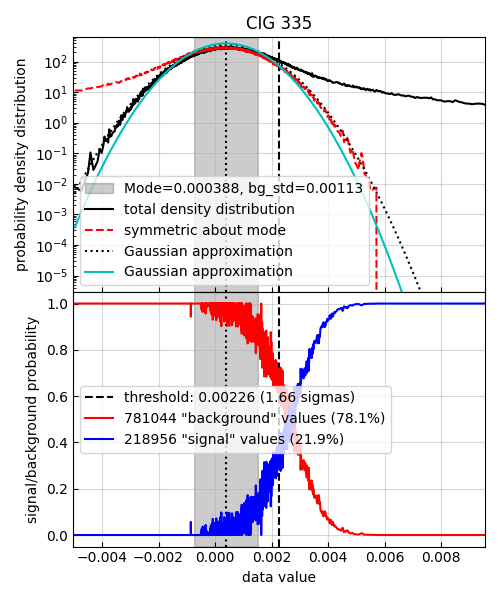

In [121]:
if plots:
    plt.close('density')
    fig = plt.figure('density', figsize=(5, 6))
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        axis.axvline(data.mode, c='k', ls=':')
        shade = axis.fill_between(data.x_rho, 0, 1, where=np.abs(data.x_rho-data.mode) <= data.bg_std,
                          color='k', alpha=0.2, transform=axis.get_xaxis_transform(),
                          label=f'Mode={data.mode:.3g}, bg_std={data.bg_std:.3g}')
        th_line = axis.axvline(data.threshold, c='k', ls='--')
    fig.set_tight_layout(True)

    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('probability density distribution')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_ylim(np.min(data.rho[data.x_rho > data.mode]), 2*np.max(data.rho))
    ax[0, 0].plot(data.x_rho, data.rho, 'k-', label='total density distribution')
    ax[0, 0].plot(data.x_rho, data.rho_symmetric, 'r--', label='symmetric about mode')
    ax[0, 0].plot(data.x_rho,
                  np.exp(-.5*((data.x_rho-data.mode)/data.bg_std)**2) * data.n_valid/data.size/np.sqrt(2*np.pi)/data.bg_std,
                  'k:', label='Gaussian approximation')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('signal/background probability')
    #ax[1, 0].set_yscale('log')
    #ax[1, 0].set_ylim(np.min(reliable_signal_probability), 1.5)
    ax[1, 0].plot(data.x_rho, data.bg_fraction, 'r-',
                  label=f'{2*data.index_mode} "background" values ({200*data.index_mode/data.n_valid:.1f}%)')
    ax[1, 0].plot(data.x_rho, 1-data.bg_fraction, 'b-',
                  label=f'{data.n_signal} "signal" values ({100*data.n_signal/data.n_valid:.1f}%)')
    shade.set_label('')
    th_line.set_label(f'threshold: {data.threshold:.3g} ({(data.threshold-data.mode)/data.bg_std:.3g} sigmas)')
    ax[1, 0].legend(loc='center left')

    ax[-1, 0].set_xlim(data.sorted[0], 2*data.threshold-data.sorted[0])
    ax[-1, 0].set_xlabel('data value')


    dummy = np.interp(data.sorted[index_mode:], 2*data.mode-data.sorted[index_mode-1::-1], index_mode-np.arange(index_mode), index_mode, 0)
$$ M_{bg}(>x) $$
$$ M_{src}(>x) = M(>x) - M_{bg}(>x) $$

$$ M_{src}(<x) = [M(<x)-M(x_0)] - [M_{bg}(<x)-M_{bg}(x_0)] = M(<x) - M_{bg}(<x_0) $$

Contamination: $M_{bg}(>x)$

Purity: $P(x) = \frac{ M_{src}(>x) }{ M(>x) } = 1 - \frac{ M_{bg}(>x) }{ M(>x) }$

Completeness: $C(x) = \frac{ M_{src}(>x) }{ M_{src} } = \frac{ M(>x) }{ M_{src} } P(x) $

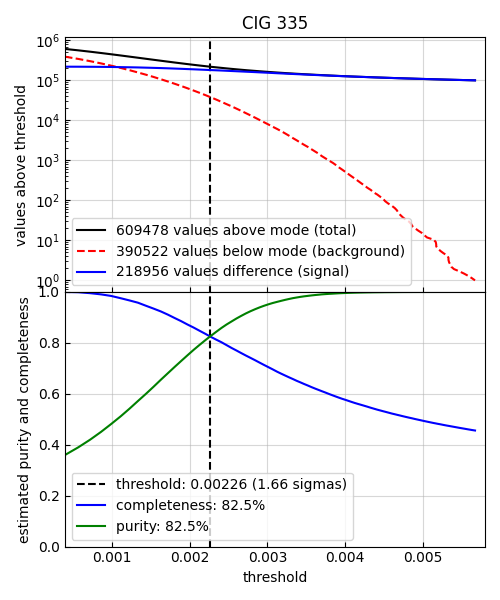

In [98]:
if plots:
    plt.close('completeness-purity')
    fig = plt.figure('completeness-purity', figsize=(5, 6))
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        th_line = axis.axvline(data.threshold, c='k', ls='--')
    fig.set_tight_layout(True)


    index_mode = np.searchsorted(data.sorted, data.mode, side='right')
    n_above_mode = data.n_valid - index_mode
    n_signal = data.n_valid - 2*index_mode
    
    bg_above_threshold = np.logspace(0, np.log10(index_mode), 100)
    threshold = 2*data.mode - np.interp(bg_above_threshold, np.arange(index_mode), data.sorted[:index_mode])
    bg_above_threshold = bg_above_threshold[::-1]
    threshold = threshold[::-1]
    total_above_threshold = np.interp(threshold, data.sorted[index_mode:], n_above_mode-np.arange(n_above_mode))
    signal_above_threshold = total_above_threshold - bg_above_threshold

    completeness = signal_above_threshold / n_signal
    purity = signal_above_threshold / total_above_threshold
    
    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('values above threshold')
    ax[0, 0].set_yscale('log')
    ax[0, 0].plot(threshold, total_above_threshold, 'k-', label=f'{n_above_mode} values above mode (total)')
    ax[0, 0].plot(threshold, bg_above_threshold, 'r--', label=f'{index_mode} values below mode (background)')
    ax[0, 0].plot(threshold, signal_above_threshold, 'b-', label=f'{n_above_mode-index_mode} values difference (signal)')
    th_line.set_label(f'threshold: {data.threshold:.3g} ({(data.threshold-data.mode)/data.bg_std:.3g} sigmas)')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('estimated purity and completeness')
    ax[1, 0].plot(threshold, completeness, 'b-', label=f'completeness: {100*data.completeness:.1f}%')
    ax[1, 0].plot(threshold, purity, 'g-', label=f'purity: {100*data.purity:.1f}%')
    ax[1, 0].legend()
    ax[1, 0].set_ylim(0, 1)

    ax[-1, 0].set_xlim(data.mode, 2*data.mode-data.sorted[0])
    ax[-1, 0].set_xlabel('threshold')


In [126]:
data_dimensionality = len(data.strides)
colour_scale = colors.SymLogNorm(vmin=data.sorted[0],
                                 #linthresh=data.threshold,
                                 linthresh=2*data.mode-data.sorted[0],
                                 vmax=data.sorted[-1])

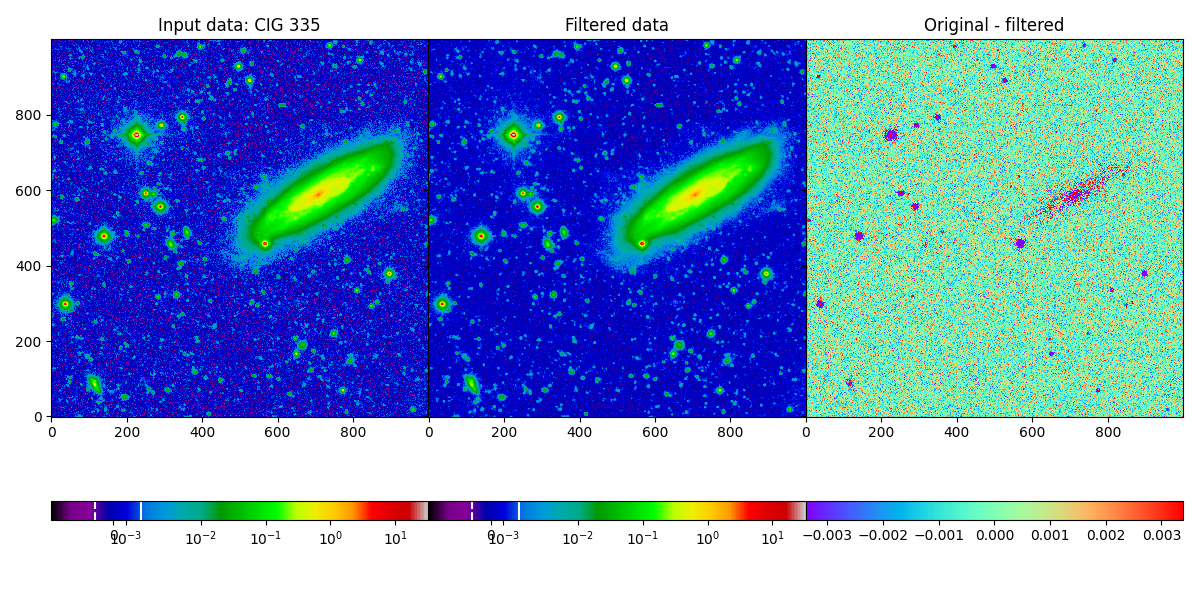

In [127]:
if plots and data_dimensionality == 2:
    plt.close('data')
    fig = plt.figure('data', figsize=(12, 6))
    ax = fig.subplots(nrows=1, ncols=3, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    #ax.tick_params(which='both', direction='in')
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data: CIG 335')
    im = ax[0, 0].imshow(data.original,
                   interpolation='nearest', origin='lower',
                   cmap='nipy_spectral', norm=colour_scale,
                  )
    #ax[0, 0].contour(data.original, levels=[data.threshold], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 0], orientation='horizontal')
    cb.ax.axvline(data.threshold, c='w')
    cb.ax.axvline(2*data.mode-data.threshold, c='w', ls='--')

    ax[0, 1].set_title('Filtered data')
    im = ax[0, 1].imshow(filtered_data,
                   interpolation='nearest', origin='lower',
                   cmap='nipy_spectral', norm=colour_scale,
                  )
    cb = fig.colorbar(im, ax=ax[0, 1], orientation='horizontal')
    cb.ax.axvline(data.threshold, c='w')
    cb.ax.axvline(2*data.mode-data.threshold, c='w', ls='--')
    
    ax[0, 2].set_title('Original - filtered')
    im = ax[0, 2].imshow(data.original - filtered_data,
                   interpolation='nearest', origin='lower',
                   #cmap='nipy_spectral', norm=colour_scale,
                   cmap='rainbow', vmin=-3*data.bg_std, vmax=3*data.bg_std,
                  )
    cb = fig.colorbar(im, ax=ax[0, 2], orientation='horizontal')
    
    plt.show()

In [128]:
np.percentile(data.original - filtered_data, [16, 50, 84])

array([-1.13181744e-03, -1.16640870e-05,  1.10556323e-03])

In [129]:
if plots and data_dimensionality == 3:
    plt.close('data')
    fig = plt.figure('data', figsize=(9, 9))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    x = data.original**2
    rms = np.sqrt(np.nanmean(x))
    colour_scale = colors.SymLogNorm(vmin=0, linthresh=2*rms, vmax=10*rms)
    
    ax[0, 0].set_title('Input data (rms value along projected axis)')
    im = ax[0, 0].imshow(np.sqrt(np.nanmean(x, axis=0)),
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[0, 0].set_ylabel('declination (celestial "latitude")')

    im = ax[0, 1].imshow(np.sqrt(np.nanmean(x, axis=2)).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[0, 1].set_xlabel('frequency channel')
    #ax[0, 1].set_aspect('auto')
    
    im = ax[1, 0].imshow(np.sqrt(np.nanmean(x, axis=1)),
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[1, 0].set_xlabel('right ascension (celestial "longitude")')
    ax[1, 0].set_ylabel('frequency channel')
    
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
    fig.set_tight_layout(True)
    
    cb = fig.colorbar(im, ax=ax[1, 1], orientation='horizontal')
    cb.ax.set_title(r'$I_{rms}(x, y) = \sqrt{\frac{1}{N_z} \sum_z I^2(x,y,z)}$')
    ax[1, 1].set_visible(False)
    plt.show()

In [130]:
if plots and data_dimensionality == 3:
    plt.close('noise_cube')
    fig = plt.figure('noise_cube', figsize=(9, 9))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    x = (data.original-filtered_data)**2
    rms = np.sqrt(np.nanmean(x))
    colour_scale = colors.SymLogNorm(vmin=0, linthresh=2*rms, vmax=10*rms)
    
    ax[0, 0].set_title('rms noise (Input data - filtered data)')
    im = ax[0, 0].imshow(np.sqrt(np.nanmean(x, axis=0)),
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[0, 0].set_ylabel('declination (celestial "latitude")')

    im = ax[0, 1].imshow(np.sqrt(np.nanmean(x, axis=2)).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[0, 1].set_xlabel('frequency channel')
    #ax[0, 1].set_aspect('auto')
    
    im = ax[1, 0].imshow(np.sqrt(np.nanmean(x, axis=1)),
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[1, 0].set_xlabel('right ascension (celestial "longitude")')
    ax[1, 0].set_ylabel('frequency channel')
    
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
    fig.set_tight_layout(True)
    
    cb = fig.colorbar(im, ax=ax[1, 1], orientation='horizontal')
    cb.ax.set_title(r'$I_{rms}(x, y) = \sqrt{\frac{1}{N_z} \sum_z I^2(x,y,z)}$')
    ax[1, 1].set_visible(False)
    plt.show()

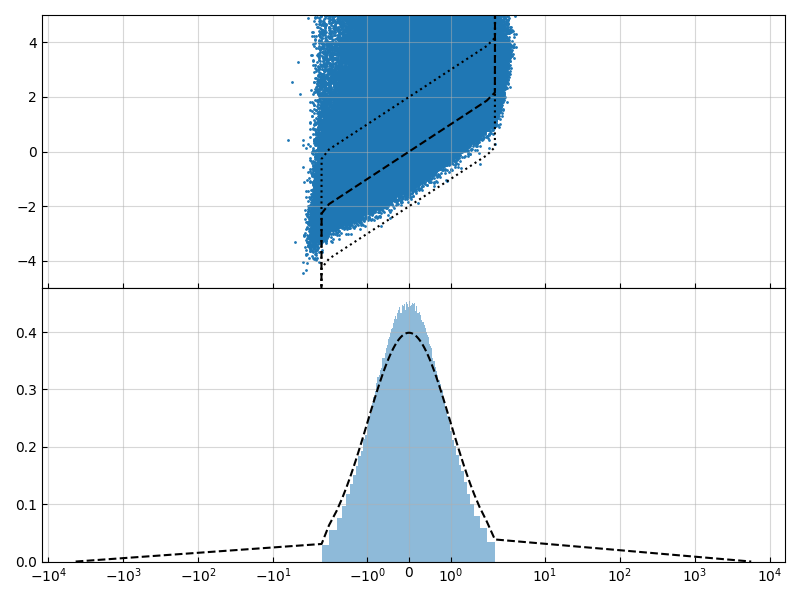

In [131]:
if plots:
    plt.close('noise')
    fig = plt.figure('noise', figsize=(8, 6))
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    expected_std = np.sqrt(1 + 1/2/data_dimensionality) * data.bg_std
    x = (data.flat - filtered_data.ravel()) /expected_std
    ax[0, 0].scatter(x, data.flat/data.bg_std, s=1)
    bins = np.percentile(x, np.linspace(0, 100, 101))
    ax[0, 0].plot(bins, bins, 'k--')
    ax[0, 0].plot(bins, bins+2, 'k:')
    ax[0, 0].plot(bins, bins-2, 'k:')
    ax[0, 0].set_ylim(-5, 5)

    ax[1, 0].hist(x, bins=bins, density=True, alpha=.5)
    ax[1, 0].plot(bins, np.exp(-.5*bins**2)/np.sqrt(2*np.pi), 'k--')
    
    
    ax[-1, 0].set_xscale('symlog')

    plt.show()

In [132]:
np.std(filtered_data), np.std(data.flat), data.bg_std, bins.size

(0.2760633307204136, 0.29016632, 0.0011294282, 101)

In [133]:
bins[bins.size*84//100], bins[bins.size*16//100], np.percentile(x, [16, 50, 84])

(0.8755278584217051,
 -0.8963193308899687,
 array([-0.89631933, -0.00923713,  0.87552786]))

## 3. Hierarchical Overdensity Tree (HOT)

### routine definition:

In [134]:
@njit
def hot(data, filtered_data, sorted_strides, argsorted_data, inverted=False, n_pixels=0):
    """Hierarchical Overdenity Tree (HOT)"""

    dimensions = len(data.strides)
    flat_data = data.ravel()
    flat_filtered = filtered_data.ravel()
    
    label = np.zeros(data.size, dtype=np.int32)
    n_labels = 0
    
    n_peaks_max = 1 + data.size//2**(dimensions-1)  # maximum number of peaks
    parent = np.zeros(n_peaks_max, dtype=np.int32)
    area = np.zeros(n_peaks_max, dtype=np.int32)
    sum_value = np.zeros(n_peaks_max, dtype=np.float64)
    sum_sqare_value = np.zeros(n_peaks_max, dtype=np.float64)
    sum_noise = np.zeros(n_peaks_max, dtype=np.float64)
    sum_sqare_noise = np.zeros(n_peaks_max, dtype=np.float64)
    #max_signal_to_noise = np.zeros(n_peaks_max, dtype=np.float32)
    #signal_to_noise_area = np.zeros(n_peaks_max, dtype=np.int32)

    if inverted:
        sorted_index = 0  # minimum
        direction = 1
    else:
        sorted_index = argsorted_data.size-1  # maximum
        direction = -1
    if n_pixels <= 0:
        n_pixels = argsorted_data.size

    pixels_so_far = 0

    while pixels_so_far < n_pixels:
        pixel = argsorted_data[sorted_index]
        pixel_value = flat_data[pixel]
        pixel_filtered = flat_filtered[pixel]
        pixel_noise = pixel_value - pixel_filtered
        #print(pixels_so_far, sorted_index, pixel, flat_filtered[pixel], pixel_value, pixel_noise)
        pixels_so_far += 1
        sorted_index += direction

        neighbour_parents = []
        for dim in range(dimensions):
            stride = sorted_strides[dim]
            remainder = pixel % sorted_strides[dim+1]  # Remember DIRTY HACK 1? ;^D
            if remainder >= stride:  # not at the "left border"
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if remainder < sorted_strides[dim+1]-stride:  # not at the "right border"
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                parent[p] = selected_parent

        label[pixel] = selected_parent
        area[selected_parent] += 1

        sum_value[selected_parent] += pixel_value
        #sum_value[selected_parent] += pixel_filtered

        #sum_sqare_value[selected_parent] += pixel_value**2
        sum_sqare_value[selected_parent] += pixel_value*pixel_filtered

        sum_noise[selected_parent] += pixel_noise
        sum_sqare_noise[selected_parent] += pixel_noise**2
        #n = area[selected_parent]
        #signal_to_noise = (sum_value[selected_parent] - n*smoothed_pixel_value) / np.sqrt(n)
        #if signal_to_noise > max_signal_to_noise[selected_parent]:
        #    max_signal_to_noise[selected_parent] = signal_to_noise
        #    signal_to_noise_area[selected_parent] = n
    
    n_src = np.count_nonzero(label)
    indep = np.where(parent[1:n_labels+1] == np.arange(1,n_labels+1))
    print(f'{n_labels} overdensities found:',
          f'{n_src} "pixels" ({int(100*n_src/data.size)}%),',
          f'{indep[0].size} independent regions',
         )
    area[0] = data.size-n_src
    test_stat = sum_sqare_value[:n_labels+1] / area[:n_labels+1] - (sum_value[:n_labels+1] / area[:n_labels+1])**2
    test_stat /= sum_sqare_noise[:n_labels+1] / area[:n_labels+1] - (sum_noise[:n_labels+1] / area[:n_labels+1])**2
    test_stat *= np.sqrt(area[:n_labels+1])
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               #sum_value[:n_labels+1],
               #sum_sqare_value[:n_labels+1],
               #np.sqrt((sum_sqare_value[:n_labels+1]/area[:n_labels+1] - (sum_value[:n_labels+1]/area[:n_labels+1])**2) * (area[:n_labels+1] - 1)),
               test_stat,
               #max_signal_to_noise[:n_labels+1],
               #signal_to_noise_area[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


### analysis of the normal image:

In [135]:
t0 = time()

label, catalog = hot(data.original,
                     filtered_data,
                     np.hstack([np.sort(data.strides), data.size]), # DIRTY HACK when testig particles at the boundary
                     #data.arg_sorted,
                     filtered_argsort,
                     inverted=False,
                     #n_pixels=data.n_signal,
                     n_pixels=data.n_valid,
                     #n_pixels=data.n_valid-data.index_mode,
                    )
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]
print(f'time elapsed: {time()-t0:.3g} s')

193089 overdensities found: 1000000 "pixels" (100%), 1 independent regions
time elapsed: 1.46 s


### selectrion criterion:

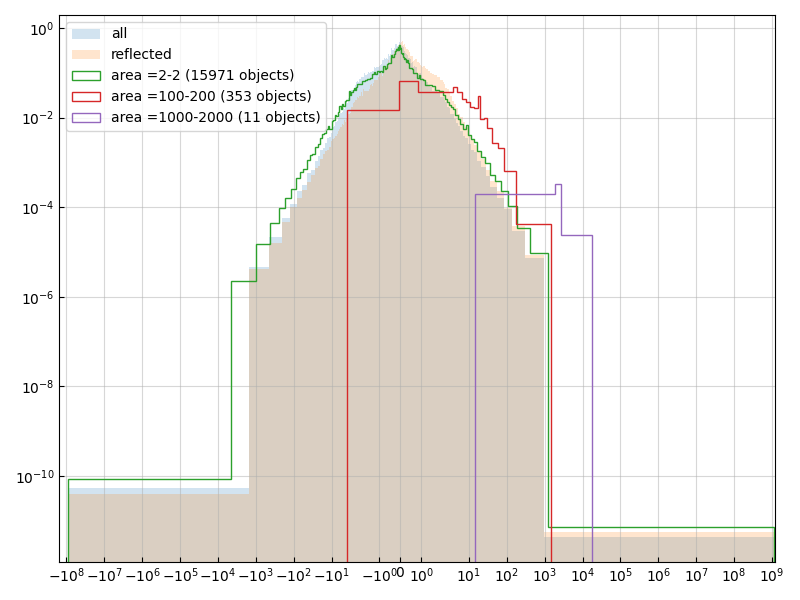

In [137]:
if plots:
    plt.close('test_stat')
    fig = plt.figure('test_stat', figsize=(8, 6))
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)
    
    
    
    def plot_area(a_min, a_max):
        x = test_stat[(area >= a_min) & (area <= a_max)]
        x = x[np.isfinite(x)]
        bins = np.percentile(x, np.linspace(0, 100, int(np.sqrt(x.size)+1)))
        ax[0, 0].hist(x, bins=bins, histtype='step', density=True, label=f'area ={a_min}-{a_max} ({x.size} objects)')

    x = test_stat[np.isfinite(test_stat)]
    bins = np.percentile(x, np.linspace(0, 100, int(np.sqrt(x.size)+1)))
    ax[0, 0].hist(x, bins=bins, alpha=.2, density=True, label=f'all')
    ax[0, 0].hist(-x, bins=bins, alpha=.2, density=True, label=f'reflected')
    plot_area(2, 2)
    #plot_area(3, 3)
    #plot_area(4, 4)
    #plot_area(5, 10)
    #plot_area(10, 20)
    #plot_area(50, 100)
    plot_area(100, 200)
    plot_area(1000, 2000)

    ax[0, 0].legend()
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_xscale('symlog')

    plt.show()

In [48]:
negative = np.where(test_stat <= 0)
#argsort_negative = np.argsort(area[negative])[::-1]
a_negative = np.sort(area[negative])
n_negative = np.arange(a_negative.size)[::-1]

positive = np.where(test_stat > 0)
#argsort_positive = np.argsort(area[positive])[::-1]
a_positive = np.sort(area[positive])
n_positive = np.arange(a_positive.size)[::-1]
n_negative_interp = np.interp(a_positive, a_negative, n_negative)
difference = n_positive - n_negative_interp

area_threshold_min = np.max(a_positive[difference < 0]) + 1
max_diff = np.argmax(difference[a_positive > area_threshold_min])
n_guess = int(difference[a_positive > area_threshold_min][max_diff])
area_threshold_max = a_positive[a_positive > area_threshold_min][max_diff]

possible_overdensity = (test_stat > 0) & (area > area_threshold_min)
test_stat_threshold_max = np.sort(test_stat[possible_overdensity])[-n_guess]
possible_overdensity = (test_stat > 0) & (area > area_threshold_max)
test_stat_threshold_min = np.sort(test_stat[possible_overdensity])[-n_guess]

possible_overdensity = (test_stat > test_stat_threshold_min) & (area > area_threshold_min)
reliable_overdensity = (test_stat > test_stat_threshold_max) & (area > area_threshold_max)

print(np.count_nonzero(possible_overdensity), np.count_nonzero(reliable_overdensity))

ValueError: attempt to get argmax of an empty sequence

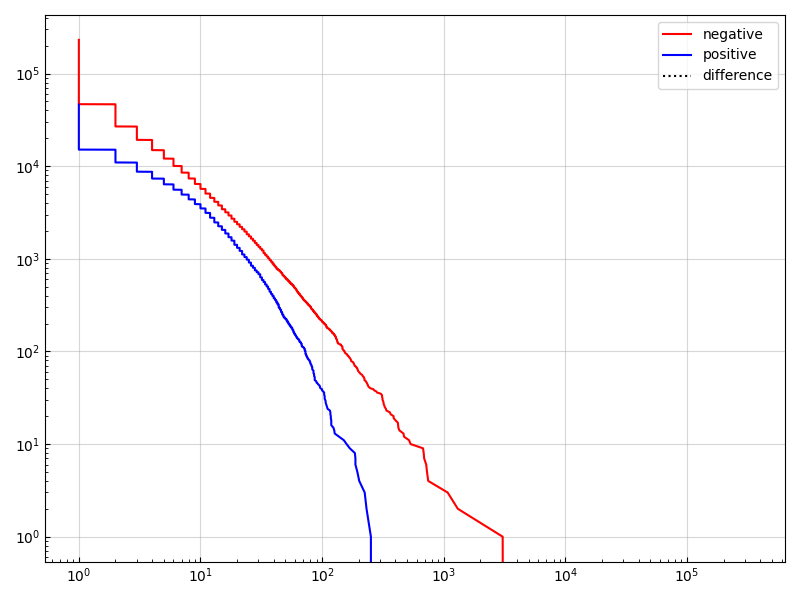

In [50]:
if plots:
    plt.close('cumulative_test_stat')
    fig = plt.figure('cumulative_test_stat', figsize=(8, 6))
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].plot(a_negative, n_negative, 'r-', label='negative')
    ax[0, 0].plot(a_positive, n_positive, 'b-', label='positive')
    ax[0, 0].plot(a_positive, difference, 'k:', label='difference')

    #ax[0, 0].axvline(area_threshold_min, c='k', ls=':', label=f'area > {area_threshold_min}')
    #ax[0, 0].axvline(area_threshold_max, c='k', ls='--', label=f'area > {area_threshold_max}')
    #ax[0, 0].plot(area_threshold_max, n_true, 'k*', label=f'max. excess: {n_true}')

    ax[0, 0].legend()
    ax[0, 0].set_xscale('log')
    ax[0, 0].set_yscale('log')

    plt.show()

In [ ]:
if plots:
    plt.close('catalogue_selection')
    fig = plt.figure('catalogue_selection')
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)
    
    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('test statistic')
    ax[0, 0].scatter(area[1:], test_stat[1:], s=25, c='c', alpha=.1)
    ax[0, 0].scatter(area[~possible_overdensity], -test_stat[~possible_overdensity], s=10, c='r', alpha=.25)
    ax[0, 0].scatter(area[possible_overdensity], test_stat[possible_overdensity], s=1, c='k')
    ax[0, 0].scatter(area[reliable_overdensity], test_stat[reliable_overdensity], s=5, c='b', marker='*')

    ax[0, 0].axvline(area_threshold_min, c='k', ls=':', label=f'area > {area_threshold_min}')
    ax[0, 0].axhline(test_stat_threshold_min, c='k', ls=':', label=f'test statistic > {test_stat_threshold_min:.2f}')
    ax[0, 0].axvline(area_threshold_max, c='k', ls='--', label=f'area > {area_threshold_max}')
    ax[0, 0].axhline(test_stat_threshold_max, c='k', ls='--', label=f'test statistic > {test_stat_threshold_max:.2f}')

    #ax[0, 0].set_xlim(.5, 3e3)
    #ax[0, 0].set_ylim(-15, 45)
    ax[0, 0].legend()

    ax[-1, 0].set_xscale('log')
    ax[-1, 0].set_xlabel('number of pixels')

In [ ]:
true_overdensity = (area > 800) & (test_stat > 1000)

In [ ]:
true_overdensity = reliable_overdensity

In [ ]:
true_overdensity = possible_overdensity

## 8. Clean-up

### prune HOT based on selection threshold

In [ ]:
original_labels = np.arange(parent.size)
island = (parent == original_labels)
pruned_labels = np.zeros_like(original_labels)
pruned_labels[true_overdensity | ~island] = original_labels[true_overdensity | ~island]

pruned_OK = true_overdensity[pruned_labels]
to_go = np.count_nonzero(~pruned_OK)
while True:
    print(f'{to_go} yet to go')
    pruned_labels[~pruned_OK] = parent[pruned_labels[~pruned_OK]]
    pruned_OK = true_overdensity[pruned_labels]
    still_to_go = np.count_nonzero(~pruned_OK)
    if still_to_go == to_go:
        break
    else:
        to_go = still_to_go
        #break

pruned_labels[~pruned_OK] = 0

In [ ]:
if plots and data_dimensionality == 2:
    segmentation = segm.SegmentationImage(label)
    pruned_segmentation = segm.SegmentationImage(pruned_labels[label])
    plt.close('HOT')
    fig = plt.figure('HOT', figsize=(9.5, 6))
    fig.set_tight_layout(True)
    ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data.original,
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax[0, 0])

    ax[0, 1].set_title(f'Initial segmentation\n({parent.size} candidates)')
    im = ax[0, 1].imshow(
        label,
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])

    ax[0, 2].set_title('Parent')
    im = ax[0, 2].imshow(
        parent[label],
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 2])

    #ax[1, 0].set_title('Max value')
    #ax[1, 0].set_title('Contrast')
    #ax[1, 0].set_title('Max S/N')
    ax[1, 0].set_title('Test statistic')
    im = ax[1, 0].imshow(
        #max_value[label]-min_value[label],
        test_stat[label]/np.sqrt(100/area[label]),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm=colour_scale,
        #vmax=np.nanmax(test_stat_inv[1:])
        vmax=3,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    '''
    ax[1, 1].set_title('S/N threshold')
    im = ax[1, 1].imshow(
        #saddle_value[label],
        signal_to_noise_threshold[label],
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    '''
    ax[1, 1].set_title('Pruned segmentation')
    im = ax[1, 1].imshow(
        pruned_segmentation,
        interpolation='nearest', origin='lower', cmap=pruned_segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 1])

    ax[1, 2].set_title('Area')
    im = ax[1, 2].imshow(
        area[label],
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(),
        )
    cb = fig.colorbar(im, ax=ax[1, 2])


### rename labels and create final catalogues

In [ ]:
final_labels = pruned_labels.astype(np.int32)
old_label = np.sort(np.unique(pruned_labels))
new_label = np.zeros_like(parent)
n_final_labels = old_label.size
print(f'{n_final_labels} objects after mode filtering')

for i, lbl in enumerate(old_label):
    new_label[lbl] = i
    final_labels[final_labels == lbl] = i

new_parent = new_label[parent[old_label]]
final_labels = new_label[pruned_labels[label]]

In [ ]:
#final_labels[data < signal_to_noise_threshold[label]] = 0

In [ ]:
if plots and data_dimensionality == 2:
    final_selection = segm.SegmentationImage(final_labels)
    final_cmap = final_selection.make_cmap(seed=123)
    final_catalog = segm.SourceCatalog(data.original, final_selection)
    final_catalog.to_table()

In [ ]:
if plots and data_dimensionality == 2:
    plt.close('segmentation')
    fig = plt.figure('segmentation', figsize=(10, 4.5))
    ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title(object_name)
    im = ax[0, 0].imshow(
        data.original,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    #ax[0, 0].contour(final_labels, levels=[0.5], colors=['k'])
    #ax[0, 0].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 0])
    #cb.ax.axhline(data.mode, c='k', ls=':')
    cb.ax.axhline(data.threshold, c='w', ls='--')
    cb.ax.axhline(2*data.mode-data.threshold, c='w', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='w')
    #ax[0, 0].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='o')
    ax[0, 0].scatter(final_catalog.maxval_xindex, final_catalog.maxval_yindex, s=25, c='w', marker='+')

    '''
    ax[0, 1].set_title('Smoothed data')
    im = ax[0, 1].imshow(
        smoothed_data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[0, 1].contour(final_labels, levels=[0.5])
    #ax[0, 1].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(smoothed_data.mode, c='k', ls=':')
    cb.ax.axhline(smoothed_threshold_guess, c='k', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='k')
    ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='k', marker='+')
    '''
    ax[0, 1].set_title(f'segmentation ({n_final_labels} objects)')
    im = ax[0, 1].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_cmap,
        )
    ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='o')
    ax[0, 1].scatter(final_catalog.maxval_xindex, final_catalog.maxval_yindex, s=25, c='k', marker='+')
    cb = fig.colorbar(im, ax=ax[0, 1])
    final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 1], color='white')


In [ ]:
if plots and data_dimensionality == 3:
    max_map = np.nanmax(final_labels, axis=0)
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      #gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data.original, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    ax[0, 0].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(data.threshold-data.mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        np.sqrt(np.nanmean((data.original-data.mode)**2, axis=0)),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data.mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    ax[0, 1].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(data.threshold-data.mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_final_labels} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap='rainbow', vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='rainbow', vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


In [ ]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('filtered').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('filtered').get_axes()[0].get_ylim()).astype(int)
    section = (data.original[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-data.mode)
    section_lables = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.nansum(section_labels**2, axis=2).T / (np.nansum(section_labels, axis=2).T + 1e-300)
    horizontal_slit = np.nansum(section_labels**2, axis=1).T / (np.nansum(section_labels, axis=1).T + 1e-300)

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    for lbl in unique_section_labels:
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [ ]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


In [ ]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('outout/HOT_mask.fits', overwrite=True)
'''
'''
